In [1]:
%autosave 30
from IPython.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))
import importlib as imp
import utils_models as fx
import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

Autosaving every 30 seconds


### Workflow
- Genero les matrius (num_samples, 2000) per tal de passarles pel model 1 i model 2
- Per cada sample de la matriu, poso un index temporal sobre a quin temps del full rec aquella sample pertany
- Si dona la casualitat que shan concatenat dos waveforms en diferents temps, agafo la del primer
- Agafo les samples que estan per sobre del thr (per entrenar autoencoder) i les de sota (unknowns) per testejar autoencoders
- La validació dels unknows després de passar pels AE, es miren amb MSE i amb referència temporal

### Compute the predicted label, probability and time index

In [68]:
imp.reload(fx)
pattern = '*.pkl'
matching_files = glob.glob(pattern)
# get name time list
name_time_list = fx.get_nametimelist(matching_files)
names_to_test = set([i for i,_ in name_time_list])

# initialize df_pred
df_model1 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])
df_model2 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])

for name_testing_subject in names_to_test:
    print(f'================={name_testing_subject}=================')
    try: 
        del testing_data, testing_states, testing_indices
        gc.collect()
    except:
        pass

    # initialize testing data
    testing_data = []
    testing_states = []
    testing_indices = []
    
    ################################################################
    print('...ORGANIZING DATA...')

    # loop over all sessions from name_testing_subject
    for name, time in name_time_list:
        if name == name_testing_subject:
            #read data
            data, states, time_indices = fx.read_data_and_metadata_and_time(name, time)

            # concatenate all sessions
            testing_data.append(data)
            testing_states.extend(states)
            testing_indices.extend(time_indices)

    testing_data = np.concatenate(testing_data, axis=0)
    
    ################################################################
    print('...Testing with MODEL 1...')
    model = fx.CNN()
    model_path = f"models_trainmain/primary_model_epoch_{name_testing_subject}_6.pth"
    model.load_state_dict(torch.load(model_path))
    
    test_data_normalized = fx.normalize_data(testing_data)
    test_labels_numeric = fx.labels_to_numbers(testing_states)
    test_dataset = TensorDataset(torch.tensor(test_data_normalized, dtype=torch.float32).unsqueeze(1),
                                 torch.tensor(test_labels_numeric, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_preds, all_labels = [], []
    all_preds_prob, all_labels_prob = [], []
    probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds_prob = torch.max(probabilities, 1)
            # preds[probabilities.max(dim=1).values < treshold_mod1] = -1
            all_preds_prob.extend(preds_prob.cpu().numpy())
            all_labels_prob.extend(labels.numpy())
            probs.append(list(probabilities.numpy()[0]))

    df_model1 = pd.concat([df_model1, 
                         pd.DataFrame({
                             'all_preds_prob': all_preds_prob, 
                             'all_labels_prob': all_labels_prob, 
                             'prob': probs, 
                             'sub': [name_testing_subject] * len(probs), 
                             'time_index': testing_indices,}
                         )], ignore_index=True)
    
    ################################################################
    print('...Testing with MODEL 2...')
    
    treshold_mod2 = 0.85 # not taken into account
    y_pred, predictions, true_classes, data_test_MA, labels_test_MA, indices_test = fx.mod2_onlypredict_and_time(name_testing_subject, testing_data, testing_states, treshold_mod2, testing_indices, norm=True)
    
    # apppend to dataframe
    df_model2 = pd.concat([df_model2, 
                         pd.DataFrame({
                             'all_preds_prob': y_pred.reshape(1, -1)[0], 
                             'all_labels_prob': true_classes, 
                             'prob': predictions.reshape(1, -1)[0], 
                             'sub': [name_testing_subject] * len(predictions.reshape(1, -1)[0]), 
                             'time_index': indices_test,}
                         )], ignore_index=True)
    
    

    
# save the dataframes
df_model1.to_pickle(f'model_df_probs/df_pred_model1_AE.pkl')       
df_model2.to_pickle(f'model_df_probs/df_pred_model2_AE.pkl')          

=================Carrie=================
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Carrie_10.h5
169/169 [==============================] - 2s 14ms/step
=================Monica=================
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Monica_10.h5
276/276 [==============================] - 4s 14ms/step
=================Natasha=================
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Natasha_10.h5
329/329 [==============================] - 5s 14ms/step
=================Smith=================
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Smith_10.h5
98/98 [==============================] - 1s 14ms/step
=================Skipper=================
...ORGANIZING DATA..

### Build training and testing datasets for AUTOENCODERS
- Training --> samples over confidence threshold
- Testing --> samples below confidence threshold

For model 1:
- Only AW and SO samples go to training and testing

For model 2:
- The MA samples from Model 1 go to training and testing (labelled as asynch_MA or slow_MA)

In [581]:
df_model1_sub

all_preds_prob all_labels_prob  \
110261              2               2   
110262              2               2   
110263              2               2   
110264              2               2   
110265              2               2   
...               ...             ...   
155333              1               1   
155334              1               1   
155335              1               1   
155336              1               1   
155337              2               1   

                                              prob     sub  time_index  \
110261   [9.939819e-05, 1.1217767e-07, 0.99990046]  Phoebe   3142000.0   
110262      [0.07540909, 7.1803224e-06, 0.9245838]  Phoebe   8417200.0   
110263     [6.181291e-07, 2.457597e-16, 0.9999994]  Phoebe   8754633.0   
110264    [9.644996e-05, 3.9699762e-07, 0.9999032]  Phoebe   8762833.0   
110265    [8.850406e-06, 2.2688526e-14, 0.9999912]  Phoebe   8773433.0   
...                                            ...     ...         ...   
155333     [0.0006141928, 0.9993794, 6.405045e-06]  Phoebe  15648071.0   
155334     [0.0010502829, 0.9977968, 0.0011529987]  Phoebe  15650071.0   
155335     [7.852737e-05, 0.9985613, 0.0013601735]  Phoebe  15652071.0   
155336  [4.7811864e-07, 0.99974614, 0.00025338106]  Phoebe  15654071.0   
155337       [0.021188557, 0.26660845, 0.71220297]  Phoebe  15656071.0   

        prob_max  
110261  0.999900  
110262  0.924584  
110263  0.999999  
110264  0.999903  
110265  0.999991  
...          ...  
155333  0.999379  
155334  0.997797  
155335  0.998561  
155336  0.999746  
155337  0.712203  

[45077 rows x 6 columns]

In [638]:
name_time_list

[('Carrie', '210108'),
 ('Monica', '210724'),
 ('Monica', '210731'),
 ('Natasha', '211211'),
 ('Natasha', '220107'),
 ('Phoebe', '210620'),
 ('Phoebe', '210626'),
 ('Phoebe', '210717'),
 ('Phoebe', '210725'),
 ('Skipper', '210123'),
 ('Smith', '210206'),
 ('Stanford', '211205'),
 ('Stanford', '211228')]

In [642]:
imp.reload(fx)
pattern = '*.pkl'
matching_files = glob.glob(pattern)
# get name time list
name_time_list = fx.get_nametimelist(matching_files)
names_to_test = set([i for i,_ in name_time_list])

# define confidence threshold to be considered unknown
thr = {'model1': 0.9, 'model2': 0.9}

# initialize df_pred
df_model1 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])
df_model2 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])

train_dataAE = np.array([])
test_dataAE = np.array([])
train_statesAE = []
test_statesAE = []
train_indices_AE = []
test_indices_AE = []
test_probs_AE = []

for ndx, name_testing_subject in enumerate(names_to_test):
    print(f'================={name_testing_subject}=================')
    try: 
        del testing_data, testing_states, testing_indices
        gc.collect()
    except:
        pass

    # initialize testing data
    testing_data = []
    testing_states = []
    testing_indices = []

    ################################################################
    print('...ORGANIZING DATA FOR MODEL 1...')

    # loop over all sessions from name_testing_subject
    for name, time in name_time_list:
        if name == name_testing_subject:
            #read data
            data, states, time_indices = fx.read_data_and_metadata_and_time(name, time)

            # concatenate all sessions
            testing_data.append(data)
            testing_states.extend(states)
            testing_indices.extend(time_indices)

    testing_data = np.concatenate(testing_data, axis=0)
    
    # normalize
    test_data_normalized = fx.normalize_data(testing_data)

    ################################################################
    print('...LOADING RESULTS MODEL 1...')

    # load results model 1 
    df_model1 = pd.read_pickle(f'model_df_probs/df_pred_model1_AE.pkl')
    df_model1['prob_max'] = [max(df_model1['prob'].iloc[i]) for i in range(len(df_model1))]

    # get df for specific subject being studied
    df_model1_sub = df_model1.loc[df_model1['sub']==name_testing_subject]

    # get the indices of the samples that belong to either train or test (taking all 0 or 1 index from prediction, not ground truth)
    train_indices = np.where(((df_model1_sub['prob_max'] > thr['model1'])&(df_model1_sub['all_preds_prob'].isin([0, 1]))))[0]
    test_indices = np.where(((df_model1_sub['prob_max'] < thr['model1'])&(df_model1_sub['all_preds_prob'].isin([0, 1]))))[0]
    
    # get probabilities for test
    test_probs_AE.extend([df_model1_sub['prob_max'].iloc[i] for i in test_indices])

    # get states based on prediction
    test_states = [df_model1_sub['all_preds_prob'].iloc[i] for i in test_indices]
    train_states = [df_model1_sub['all_preds_prob'].iloc[i] for i in train_indices]

    # append to train or test
    test_dataAE = np.vstack([test_dataAE, test_data_normalized[test_indices, :]]) if test_dataAE.size else test_data_normalized[test_indices, :]
    train_dataAE = np.vstack([train_dataAE, test_data_normalized[train_indices, :]]) if train_dataAE.size else test_data_normalized[train_indices, :]

    # append labels 
    test_statesAE.extend(test_states) # states are based on prediction, not real label
    train_statesAE.extend(train_states) # states are based on prediction, not real label
    test_indices_AE.extend([testing_indices[i] for i in test_indices])
    train_indices_AE.extend([testing_indices[i] for i in train_indices])

    ################################################################
    print('...LOADING RESULTS MODEL 2...')

    # load results model 2 
    df_model2 = pd.read_pickle(f'model_df_probs/df_pred_model2_AE.pkl')

    # get df for specific subject being studied
    df_model2_sub = df_model2.loc[df_model2['sub']==name_testing_subject]

    ################################################################
    print('...ORGANIZING DATA FOR MODEL 2...')

    # here we are inputting all ma data from ground truth 
    data_m2, labels_m2, indices_m2 = fx.organize_datamodel2(testing_data, testing_states, df_model2_sub)

    # get the indices of the samples that belong to either train or test
    train_indices = np.where(((df_model2_sub['prob'] > thr['model2']) | (df_model2_sub['prob'] < 1-thr['model2'])))[0]
    test_indices = np.where(((df_model2_sub['prob'] < thr['model2']) & (df_model2_sub['prob'] > 1-thr['model2'])))[0]
    
    # get probabilities for test
    test_probs_AE.extend([df_model2_sub['prob'].iloc[i] for i in test_indices])

    # append to train or test
    test_dataAE = np.vstack([test_dataAE, data_m2[test_indices, :]]) if test_dataAE.size else data_m2[test_indices, :]
    train_dataAE = np.vstack([train_dataAE, data_m2[train_indices, :]]) if train_dataAE.size else data_m2[train_indices, :]

    # append labels 
    test_statesAE.extend([df_model2_sub['all_preds_prob'].values[i]+2 for i in test_indices])
    train_statesAE.extend([df_model2_sub['all_preds_prob'].values[i]+2 for i in train_indices])
    test_indices_AE.extend([testing_indices[i] for i in test_indices])
    train_indices_AE.extend([testing_indices[i] for i in train_indices])   

print(f'Test shape {test_dataAE.shape[0]} ({test_dataAE.shape[0] / (test_dataAE.shape[0] + train_dataAE.shape[0])})')
print(f'Train shape {train_dataAE.shape[0]} ({train_dataAE.shape[0] / (test_dataAE.shape[0] + train_dataAE.shape[0])})')

=================Phoebe=================
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...


IndexError: index 12160 is out of bounds for axis 0 with size 11498

### Split TRAIN data into TRAINING and VALIDATION for testing MSE and KL

In [636]:
imp.reload(fx)
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
waveforms_train = {}
waveforms_validation = {}
waveforms_unknown = {}
test_size = 0.10
validation_size = 0.10  # This will represent 10% of the training set
for state_train in set(train_statesAE):
    indices = np.where(np.array(train_statesAE) == state_train)[0]
    waveforms_train_state, waveforms_test_state = train_test_split(train_dataAE[indices, :], test_size=test_size)
#     waveforms_train_state, waveforms_test_state, time_indices_train_state, time_indices_test_state = train_test_split(train_dataAE[indices, :], np.array(train_indices_AE)[indices], test_size=test_size)
    # further split the training set into training and validation subsets
    waveforms_train_state, waveforms_validation_state = train_test_split(waveforms_train_state, test_size=validation_size)
    waveforms_train[state_train] = waveforms_train_state
    waveforms_test[state_train] = waveforms_test_state
    waveforms_validation[state_train] = waveforms_validation_state
    
    # split unknowns
    indices_unknown = np.where(np.array(test_statesAE) == state_train)[0]
    waveforms_unknown[state_train] = test_dataAE[indices_unknown, :]
    print(state_train, len(indices), np.mean(np.std(waveforms_train_state, axis=1)), np.mean(np.std(waveforms_test_state, axis=1)), np.mean(np.std(waveforms_validation_state, axis=1)))


0 4336 1.0 1.0 1.0
1 79605 1.0 1.0 1.0
2 24530 1.0 1.0 1.0
3 15085 1.0 1.0 1.0


In [623]:
with open('autoencoders/autoencoders_train.pkl', 'wb') as file:
    pickle.dump(waveforms_train, file)
with open('autoencoders/autoencoders_test.pkl', 'wb') as file:
    pickle.dump(waveforms_test, file)
with open('autoencoders/autoencoders_validation.pkl', 'wb') as file:
    pickle.dump(waveforms_validation, file)
with open('autoencoders/autoencoders_unknown.pkl', 'wb') as file:
    pickle.dump(waveforms_unknown, file)

numpy.ndarray

### Train AUTOENCODER

In [587]:
import os
from tensorflow.keras.models import load_model
from IPython.display import clear_output
imp.reload(fx)

# define autoencoders
autoencoders = {}
histories = {}
encoding_dim = 90 # 55 for 2 and 3 
epochs = 1200
batch_size = 512

for state_train, waveforms_state_train in waveforms_train.items():
    print(state_train, waveforms_state_train.shape[0] / (waveforms_validation[state_train].shape[0] + waveforms_state_train.shape[0]))
    model_path = 'autoencoder_simpl_{}_{}.h5'.format(state_train, test_size)
    if os.path.exists(f'autoencoders/{model_path}'):
        autoencoders[state_train] = load_model(f'autoencoders/{model_path}')
    else:
        autoencoder, history = fx.train_autoencoder_validation(waveforms_state_train, waveforms_validation[state_train], encoding_dim=encoding_dim, epochs=epochs, batch_size=batch_size)
        autoencoder.save(f'autoencoders/{model_path}')
        autoencoders[state_train] = autoencoder
        histories[state_train] = history
    clear_output()
print('encoders are loaded')

encoders are loaded


<IPython.core.display.Javascript object>


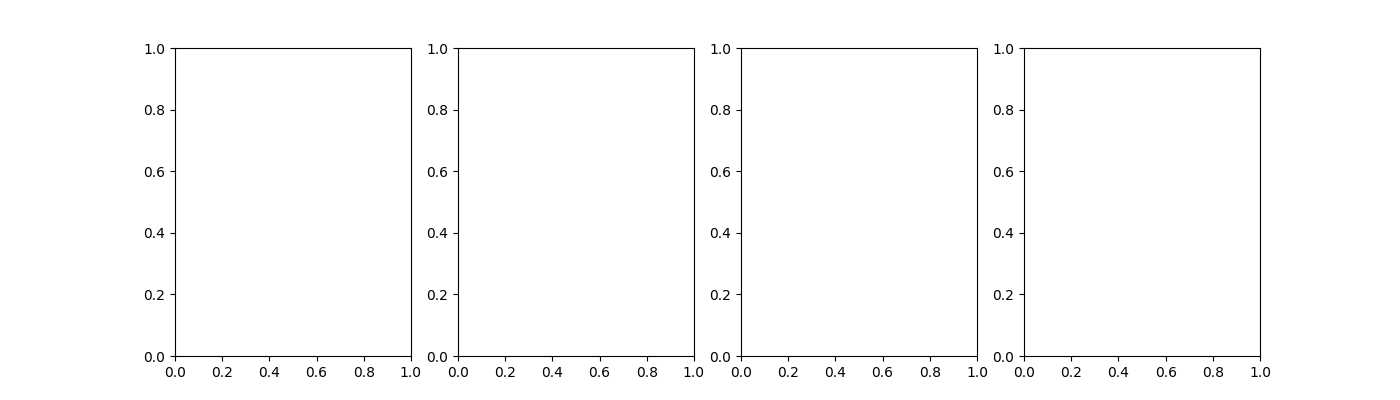

In [559]:
# Plotting the loss function
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))
for sdx, (state_train, history) in enumerate(histories.items()):
    ax[sdx].plot(history.history['loss'], label='Training Loss')
    ax[sdx].plot(history.history['val_loss'], label='Validation Loss')
    ax[sdx].set_title(f'Loss for State: {state_train}')
    ax[sdx].set_xlabel('Epoch')
    ax[sdx].set_ylabel('Loss')
    ax[sdx].legend()

<IPython.core.display.Javascript object>


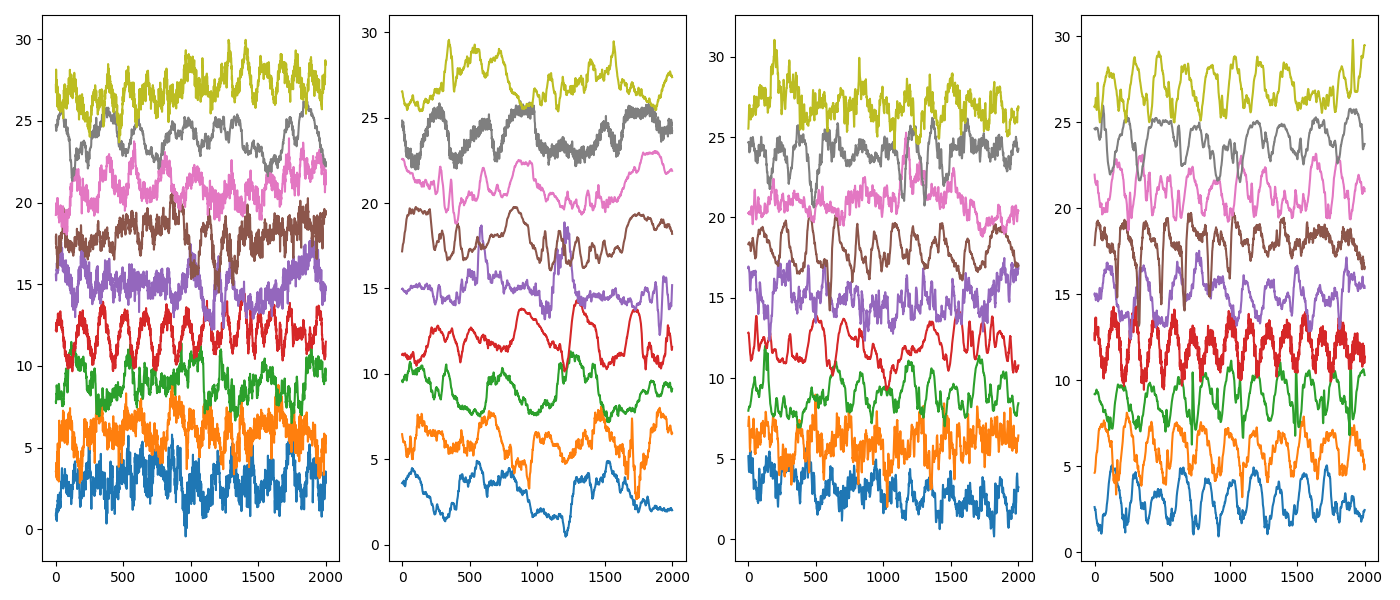

In [612]:
fi, ax = plt.subplots(ncols=4, figsize=(14, 6))
a = np.random.choice(waveforms_validation[0].shape[0], 1)[0]
for i in range(1, 10):
    ax[0].plot(3*i + waveforms_validation[0][a+i, :])
    ax[1].plot(3*i + waveforms_validation[1][a+i, :])
    ax[2].plot(3*i + waveforms_validation[2][a+i, :])
    ax[3].plot(3*i + waveforms_validation[3][a+i, :])
plt.tight_layout()

In [597]:
def kl_divergence(p, q):
    # Where the arrays have zero or close to zero values, replace them with a small positive constant
    p = np.where(p <= 1e-10, 1e-10, p)
    q = np.where(q <= 1e-10, 1e-10, q)
    return np.sum(p * np.log(p / q))

mse_dict = {}
kl_dict = {}

In [561]:
for state_test, waveforms_state_test in waveforms_test.items():
    for state_train, autoencoder in autoencoders.items():
        reconstructed_state_test = autoencoder.predict(waveforms_state_test)

        # Calculate MSE
        mse = np.mean(np.power(waveforms_state_test - reconstructed_state_test, 2), axis=1)
        mse_dict[(state_train, state_test)] = (np.mean(mse), np.std(mse))

        # Flatten the waveforms to 1D arrays for KL divergence calculation
        original = waveforms_state_test.flatten()
        reconstructed = reconstructed_state_test.flatten()

        # Normalize the arrays to make them valid probability distributions
        original = original / np.sum(original)
        reconstructed = reconstructed / np.sum(reconstructed)

        # Calculate KL divergence
        kl_div = kl_divergence(original, reconstructed)

        kl_dict[(state_train, state_test)] = kl_div

48/48 [==============================] - 0s 4ms/step


In [598]:
# New dictionaries to store all MSE and KL values
mse_values_dict = {}
kl_values_dict = {}

for state_test, waveforms_state_test in waveforms_test.items():
    for state_train, autoencoder in autoencoders.items():
        reconstructed_state_test = autoencoder.predict(waveforms_state_test)

        # Calculate MSE
        mse = np.mean(np.power(waveforms_state_test - reconstructed_state_test, 2), axis=1)
        mse_values_dict.setdefault((state_train, state_test), []).extend(mse)

        # Flatten the waveforms to 1D arrays for KL divergence calculation
        original = waveforms_state_test.flatten()
        reconstructed = reconstructed_state_test.flatten()

        # Normalize the arrays to make them valid probability distributions
        original = original / np.sum(original)
        reconstructed = reconstructed / np.sum(reconstructed)

        # Calculate KL divergence
        kl_div = kl_divergence(original, reconstructed)
        kl_values_dict.setdefault((state_train, state_test), []).append(kl_div)

48/48 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>


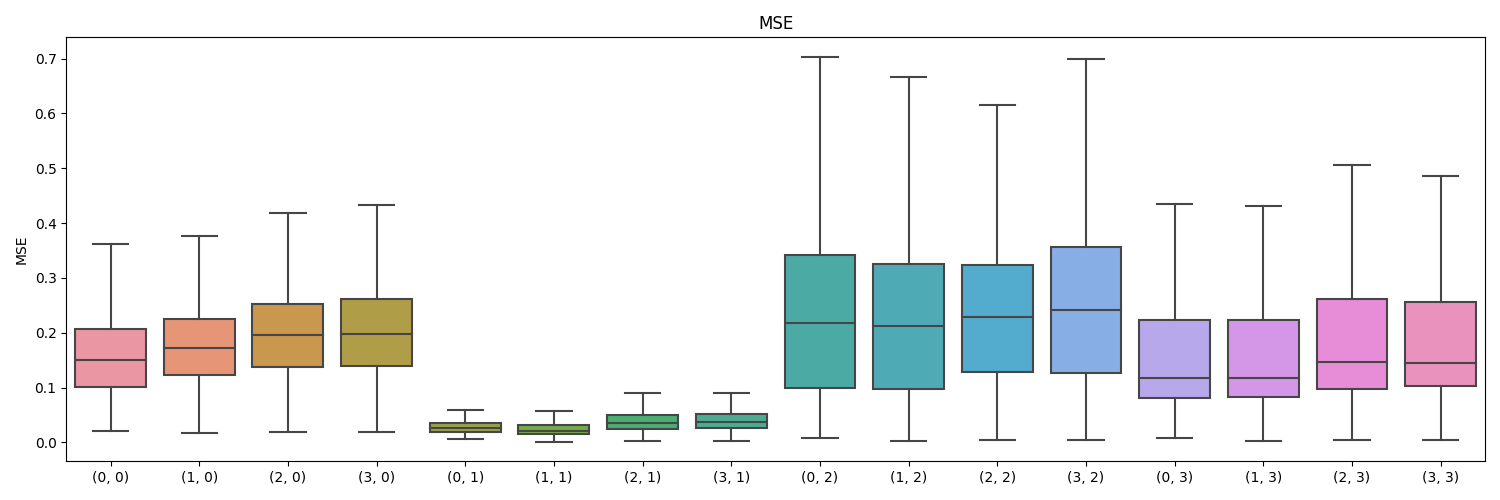

In [601]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

# Flatten keys and values to lists for easier plotting
keys = list(mse_values_dict.keys())
mse_values = list(mse_values_dict.values())
kl_values = list(kl_values_dict.values())

# Labels for the boxplots will be the string representation of the keys
labels = [str(key) for key in keys]

# Create boxplots
sns.boxplot(data=mse_values, ax=axs,showfliers=False)
# sns.boxplot(data=kl_values, ax=axs[1],showfliers=False)

# Set labels and title
axs.set_xticklabels(labels)
axs.set_title(f'MSE') # for each(train,test) states w/ test size {test_size}')
axs.set_ylabel('MSE')

# axs[1].set_xticklabels(labels)
# axs[1].set_title(f'KL for each(train,test) states w/ test size {test_size}')
# axs[1].set_ylabel('KL Divergence')
# axs.set_yscale('log')
# axs.set_title(name_testing_subject)
plt.tight_layout()
plt.show()

we obtain the tresholds here

# now we treat the unknowns

In [564]:
import pandas as pd
# Initialize a dictionary to store the MSE for each sample
mse_samples_test = {}

for state_train, autoencoder in autoencoders.items():
    predicted_samples = autoencoder.predict(test_dataAE)
    mse_samples = mean_squared_error(test_dataAE.T, predicted_samples.T, multioutput='raw_values')
    mse_samples_test[state_train] = mse_samples
# Convert the lists of MSEs to NumPy arrays for easier manipulation
for state_train in mse_samples_test.keys():
    mse_samples_test[state_train] = np.array(mse_samples_test[state_train])

# Convert the MSE dictionary to a DataFrame for easier manipulation
mse_df = pd.DataFrame(mse_samples_test)
print(mse_df.head())  # Print the first few rows of the DataFrame

961/961 [==============================] - 4s 4ms/step
          0         1         2         3
0  0.236395  0.213276  0.215153  0.230519
1  0.546586  0.368597  0.340681  0.392768
2  0.084610  0.063592  0.061704  0.069598
3  0.074054  0.062001  0.056873  0.063183
4  0.244151  0.193271  0.182213  0.204338


<IPython.core.display.Javascript object>


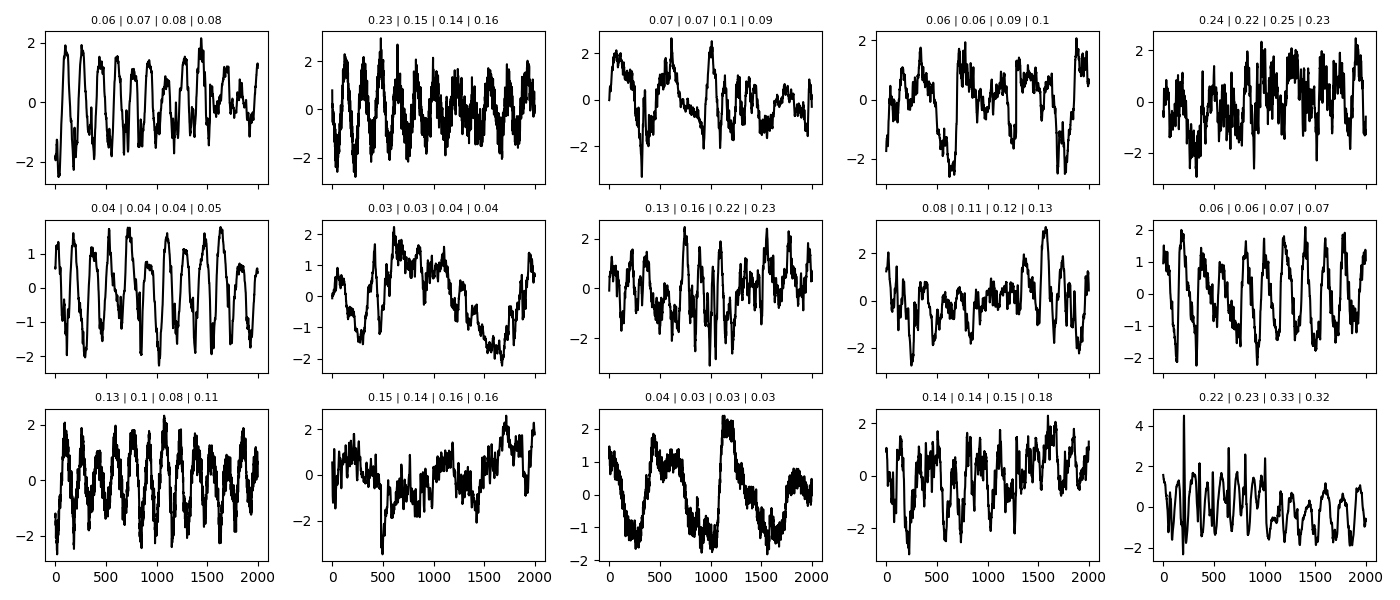

In [565]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(14, 6), sharex=True)
ax = ax.reshape(-1)
for i, idx in enumerate(np.random.choice(len(mse_df), 15)):
    ax[i].plot(test_dataAE[idx, :], c='k')
    ax[i].set_title(f'{np.round(mse_df.iloc[idx][0], 2)} | {np.round(mse_df.iloc[idx][1], 2)} | {np.round(mse_df.iloc[idx][2], 2)} | {np.round(mse_df.iloc[idx][3], 2)}', fontsize=8)
plt.tight_layout()

In [21]:
import pandas as pd
# Initialize a dictionary to store the MSE for each sample
mse_samples_state4 = {state_train: [] for state_train in autoencoders.keys()}

# Iterate over each sample in waveforms[4]
for i in range(waveforms_state_2d[4].shape[0]):
    sample = waveforms_state_2d[4][i].reshape(1, -1)  # Reshape the sample to have shape (1, n_features)

    # Use the autoencoders to predict this sample
    predicted_samples = {state_train: autoencoder.predict(sample) for state_train, autoencoder in autoencoders.items()}

    # Calculate and store the MSE for each autoencoder's prediction
    for state_train, predicted_sample in predicted_samples.items():
        mse_samples_state4[state_train].append(mean_squared_error(sample, predicted_sample))

# Convert the lists of MSEs to NumPy arrays for easier manipulation
for state_train in mse_samples_state4.keys():
    mse_samples_state4[state_train] = np.array(mse_samples_state4[state_train])

# Convert the MSE dictionary to a DataFrame for easier manipulation
mse_df = pd.DataFrame(mse_samples_state4)
print(mse_df.head())  # Print the first few rows of the DataFrame


1/1 [==============================] - 0s 6ms/step
          0         1         2         3
0  1.013052  1.233789  0.890824  1.128625
1  1.012183  1.233948  0.889050  1.126399
2  0.994843  1.221548  0.871789  1.111735
3  0.994247  1.212348  0.871970  1.107755
4  0.993838  1.215462  0.867181  1.103092


## fins aquí (Manasanch)

In [22]:
mse_df

0         1         2         3
0    1.013052  1.233789  0.890824  1.128625
1    1.012183  1.233948  0.889050  1.126399
2    0.994843  1.221548  0.871789  1.111735
3    0.994247  1.212348  0.871970  1.107755
4    0.993838  1.215462  0.867181  1.103092
..        ...       ...       ...       ...
888  1.070619  0.338184  1.106579  1.083151
889  1.066537  0.336369  1.103807  1.077342
890  1.065139  0.323797  1.099800  1.074343
891  1.061057  0.307376  1.087579  1.065572
892  1.068200  0.307089  1.095004  1.074067

[893 rows x 4 columns]

In [31]:
# Check for any MSE value below 0.7
mse_below_threshold = mse_df < 0.7 

# Print any rows which have MSE values below treshold
filtered_rows = mse_df[mse_below_threshold.any(axis=1)]

print(filtered_rows)

            0         1         2         3
118  0.688045  1.142309  1.019690  1.072046
119  0.699237  1.148533  1.031211  1.079689
121  0.683391  1.164718  1.018127  1.079216
122  0.688180  1.165101  1.020790  1.085404
123  0.668477  1.152544  1.003057  1.067261
..        ...       ...       ...       ...
888  1.070619  0.338184  1.106579  1.083151
889  1.066537  0.336369  1.103807  1.077342
890  1.065139  0.323797  1.099800  1.074343
891  1.061057  0.307376  1.087579  1.065572
892  1.068200  0.307089  1.095004  1.074067

[171 rows x 4 columns]


using this next cell we can filter to find the values that we need to generate the figure

In [28]:
# Check for any MSE value below 0.6 in state 3. 
# This way we obtain the unknowns that can be classified
mse_below_threshold_state3 = mse_df[2] > 0.6 && ms

# Print rows which have MSE values below the threshold for state 3
filtered_rows_state3 = mse_df[mse_below_threshold_state3]
print(filtered_rows_state3)


            0         1         2         3
0    1.013052  1.233789  0.890824  1.128625
1    1.012183  1.233948  0.889050  1.126399
2    0.994843  1.221548  0.871789  1.111735
3    0.994247  1.212348  0.871970  1.107755
4    0.993838  1.215462  0.867181  1.103092
..        ...       ...       ...       ...
888  1.070619  0.338184  1.106579  1.083151
889  1.066537  0.336369  1.103807  1.077342
890  1.065139  0.323797  1.099800  1.074343
891  1.061057  0.307376  1.087579  1.065572
892  1.068200  0.307089  1.095004  1.074067

[890 rows x 4 columns]


Original indices in concatenated_data from state 4: [ 21646 108971  31342  37688]
1/1 [==============================] - 0s 9ms/step


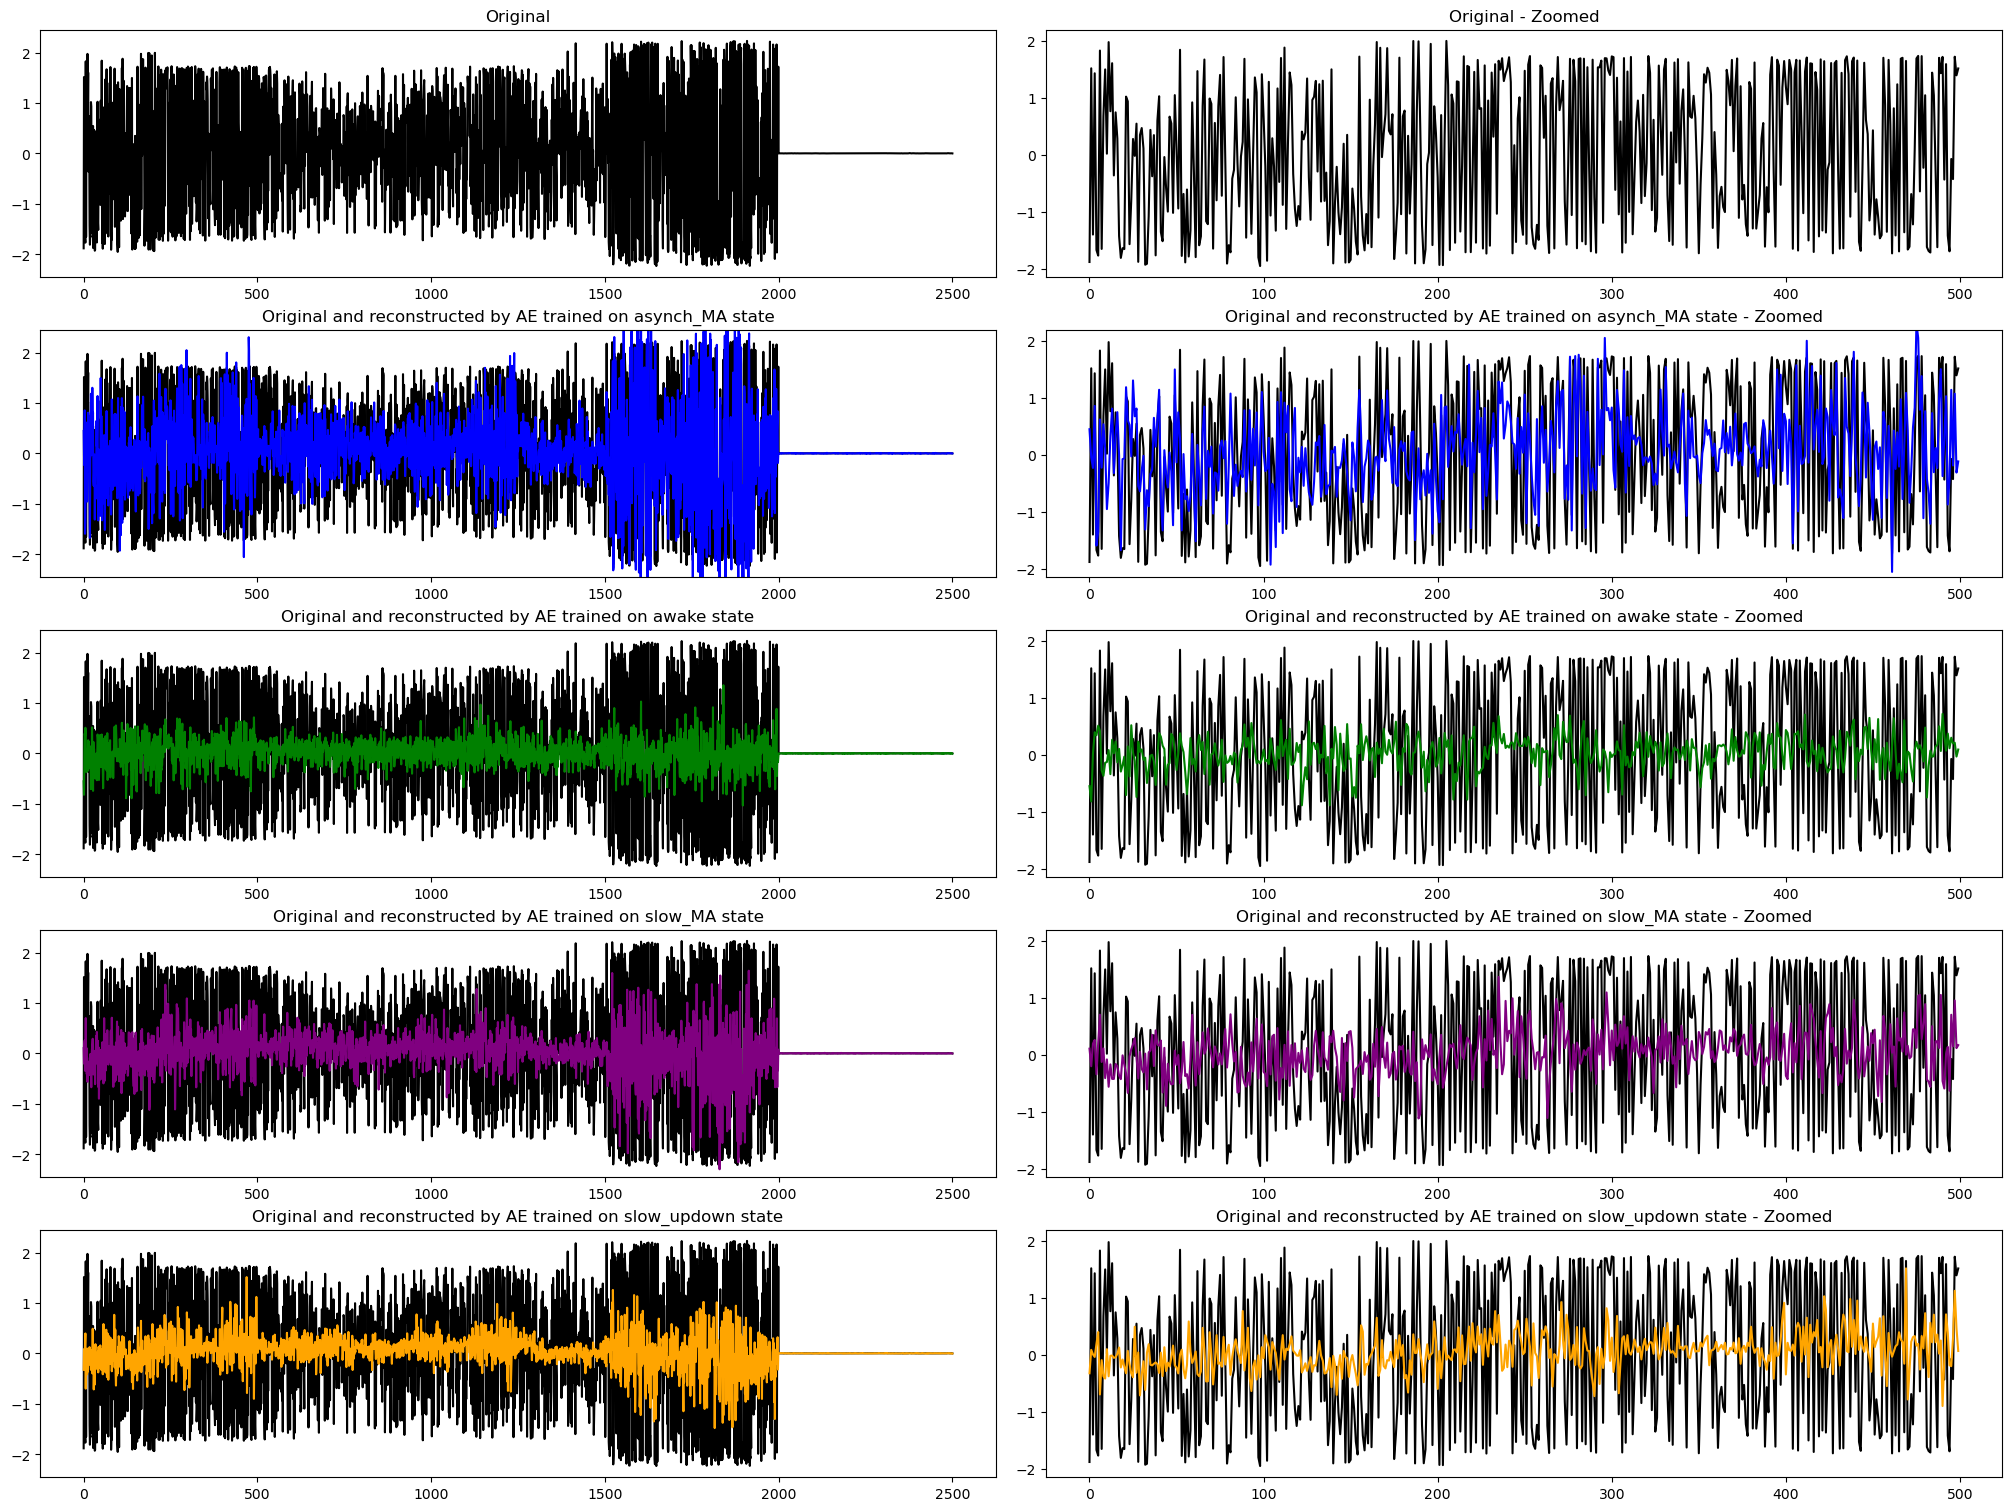

In [29]:
from utils import plot_reconstructions

# Specify indices to keep from state 4 'unknwn'
indices_i_want_to_keep = [121, 889, 256, 445]

# Get original indices from state 4
original_indices_state4 = indices_per_state[4][indices_i_want_to_keep]

print("Original indices in concatenated_data from state 4:", original_indices_state4)

from utils import plot_reconstructions

sample_idx = 121
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

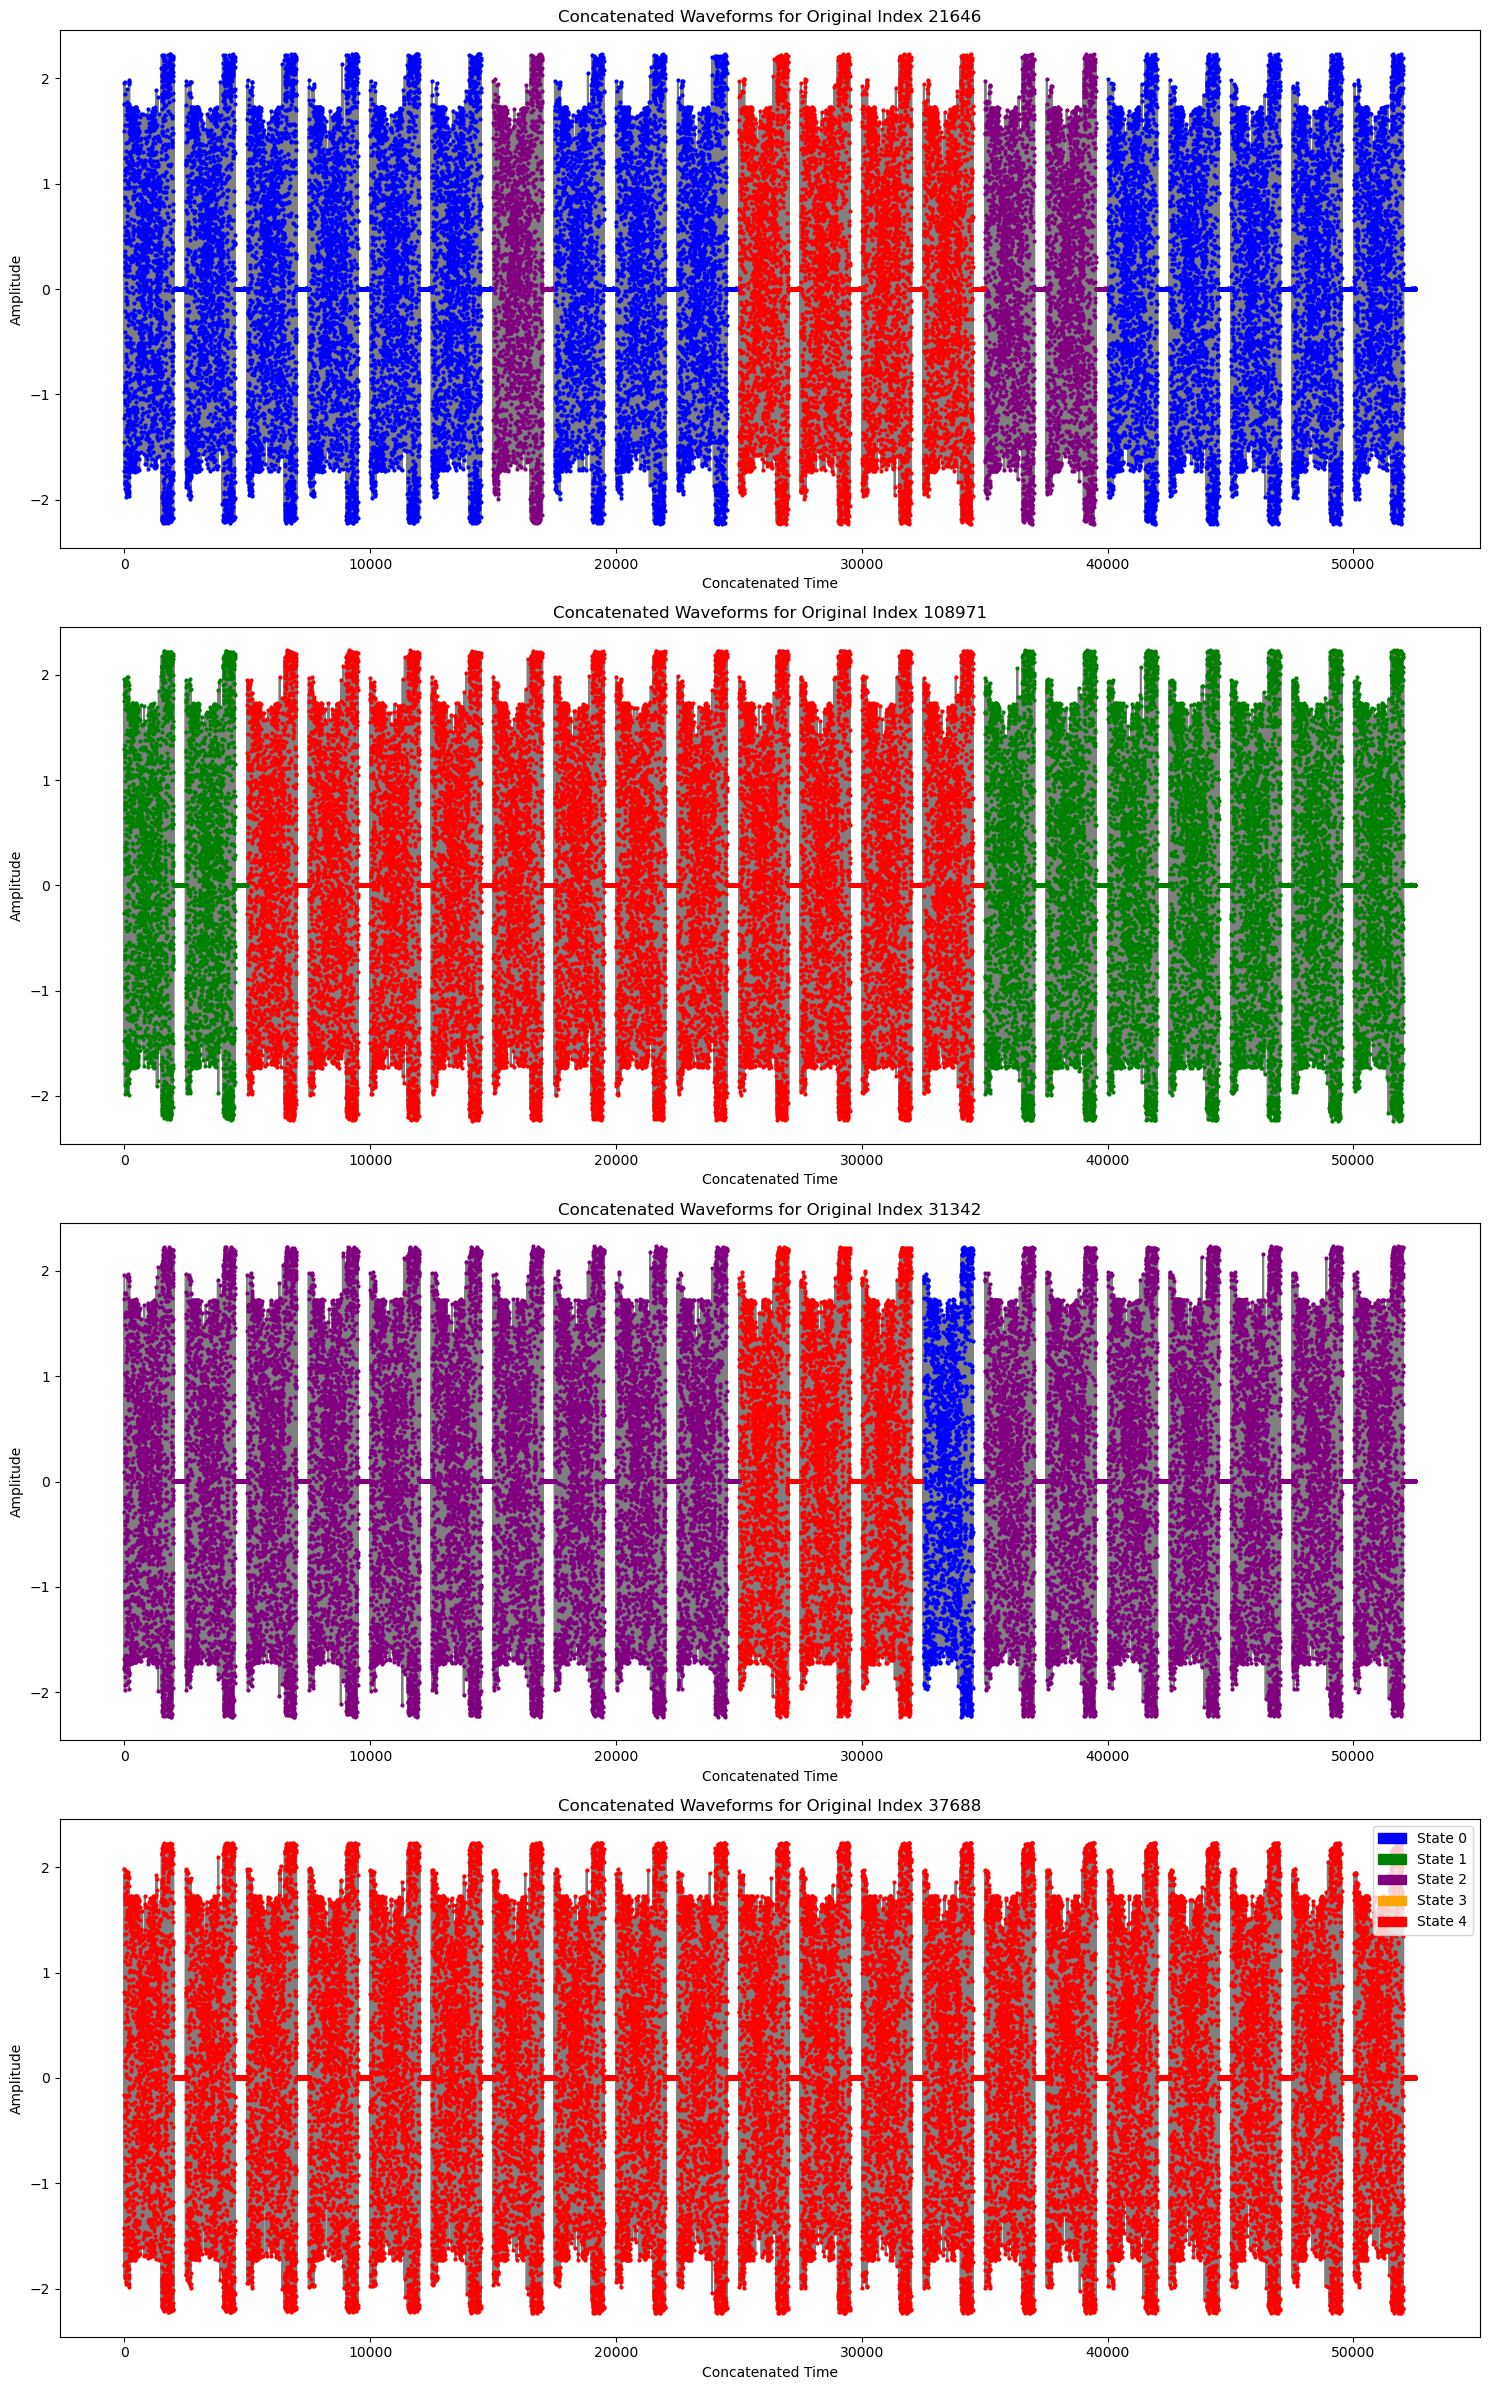

In [30]:
from utils import plot_timeseries
concatenated_data = np.load("data_train_4.npy")
concatenated_states = np.load("label_train_4.npy")
plot_timeseries(original_indices_state4,concatenated_data,concatenated_states) 

In [17]:
imp.reload(fx)
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_time = ['Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']

for name_time in names_time:
    print(name_time)
    name = name_time.split(' ')[0]
    time = name_time.split(' ')[1]
    
    # initialize df_pred
    df_model1 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])
    df_model2 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])

    
    # initialize testing data
    testing_data = []
    testing_states = []
    testing_indices = []
    gt_states = []

    ################################################################
    print('...ORGANIZING DATA...')

    # loop over all sessions from name_testing_subject
    data, states, time_indices = fx.read_data_and_metadata_and_time(name, time)

    # concatenate all sessions
    testing_data.append(data)
    testing_states.extend(states)
    testing_indices.extend(time_indices)
    testing_data = np.concatenate(testing_data, axis=0)

    ################################################################
    print('...Testing with MODEL 1...')
    model = fx.CNN()
    model_path = f"models_trainmain/primary_model_epoch_Phoebe_6.pth"
    model.load_state_dict(torch.load(model_path))

    test_data_normalized = fx.normalize_data(testing_data)
    test_labels_numeric = fx.labels_to_numbers(testing_states)
    test_dataset = TensorDataset(torch.tensor(test_data_normalized, dtype=torch.float32).unsqueeze(1),
                                 torch.tensor(test_labels_numeric, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_preds, all_labels = [], []
    all_preds_prob, all_labels_prob = [], []
    probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds_prob = torch.max(probabilities, 1)
            # preds[probabilities.max(dim=1).values < treshold_mod1] = -1
            all_preds_prob.extend(preds_prob.cpu().numpy())
            all_labels_prob.extend(labels.numpy())
            probs.append(list(probabilities.numpy()[0]))

    df_model1 = pd.concat([df_model1, 
                         pd.DataFrame({
                             'all_preds_prob': all_preds_prob, 
                             'all_labels_prob': all_labels_prob, 
                             'prob': probs, 
                             'sub': [name] * len(probs), 
                             'time_index': testing_indices,}
                         )], ignore_index=True)

    ################################################################
    print('...Testing with MODEL 2...')

    treshold_mod2 = 0.85 # not taken into account
    y_pred, predictions, true_classes, data_test_MA, labels_test_MA, indices_test= fx.mod2_onlypredict_and_time(name, testing_data, testing_states, treshold_mod2, testing_indices, norm=True)

    # apppend to dataframe
    df_model2 = pd.concat([df_model2, 
                         pd.DataFrame({
                             'all_preds_prob': y_pred.reshape(1, -1)[0], 
                             'all_labels_prob': true_classes, 
                             'prob': predictions.reshape(1, -1)[0], 
                             'sub': [name] * len(predictions.reshape(1, -1)[0]), 
                             'time_index': indices_test,}
                         )], ignore_index=True)


    # save the dataframes
    df_model1.to_pickle(f'model_df_probs/df_pred_model1_AE_{name}{time}.pkl')       
    df_model2.to_pickle(f'model_df_probs/df_pred_model2_AE_{name}{time}.pkl')       

    
    

Natasha 220107
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Natasha_10.h5
138/138 [==============================] - 2s 14ms/step
Natasha 211211
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Natasha_10.h5
191/191 [==============================] - 3s 15ms/step
Monica 210731
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Monica_10.h5
141/141 [==============================] - 2s 14ms/step
Monica 210724
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Monica_10.h5
136/136 [==============================] - 2s 14ms/step
Skipper 210123
...ORGANIZING DATA...
...Testing with MODEL 1...
...Testing with MODEL 2...
Loaded model from models_MAstates/model_MAstates_Skipper_10.h5
164/164 [=

In [25]:
model(inputs)

tensor([[-0.8284,  1.3880,  0.9367]], grad_fn=<AddmmBackward0>)

In [41]:
import pickle
imp.reload(fx)
names_time = ['Phoebe 210626', 'Phoebe 210620', 'Phoebe 210725', 'Phoebe 210717', 'Natasha 220107', 'Natasha 211211', 'Monica 210731', 'Monica 210724', 'Skipper 210123']

# define confidence threshold to be considered unknown
thr = {'model1': 0.9, 'model2': 0.9}

for name_time in names_time:
    print(name_time)
    name = name_time.split(' ')[0]
    time = name_time.split(' ')[1]

    # initialize df_pred
    df_model1 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])
    df_model2 = pd.DataFrame(columns=['all_preds_prob', 'all_labels_prob', 'prob', 'sub', 'time_index'])

    train_dataAE = np.array([])
    test_dataAE = np.array([])
    train_statesAE = []
    test_statesAE = []
    train_indices_AE = []
    test_indices_AE = []
    train_probs_AE = []
    test_probs_AE = []
    gt_train_statesAE = []
    gt_test_statesAE = []
    # initialize testing data
    testing_data = []
    testing_states = []
    testing_indices = []

    ################################################################
    print('...ORGANIZING DATA FOR MODEL 1...')

    # loop over all sessions from name_testing_subject

    data, states, time_indices = fx.read_data_and_metadata_and_time(name, time)

    # concatenate all sessions
    testing_data.append(data)
    testing_states.extend(states)
    testing_indices.extend(time_indices)

    # concatenate
    testing_data = np.concatenate(testing_data, axis=0)

    # normalize
    test_data_normalized = fx.normalize_data(testing_data)

    ################################################################
    print('...LOADING RESULTS MODEL 1...')

    # load results model 1 
    df_model1 = pd.read_pickle(f'model_df_probs/df_pred_model1_AE_{name}{time}.pkl')
    df_model1['prob_max'] = [max(df_model1['prob'].iloc[i]) for i in range(len(df_model1))]

    # get df for specific subject being studied
    df_model1_sub = df_model1.loc[df_model1['sub']==name]

    # get the indices of the samples that belong to either train or test (taking all 0 or 1 index from prediction, not ground truth)
    train_indices = np.where(((df_model1_sub['prob_max'] > thr['model1'])&(df_model1_sub['all_preds_prob'].isin([0, 1]))))[0]
    test_indices = np.where(((df_model1_sub['prob_max'] < thr['model1'])&(df_model1_sub['all_preds_prob'].isin([0, 1]))))[0]

    # get probabilities for test
    train_probs_AE.extend([df_model1_sub['prob_max'].iloc[i] for i in train_indices])
    test_probs_AE.extend([df_model1_sub['prob_max'].iloc[i] for i in test_indices])

    # get states based on prediction
    test_states = [df_model1_sub['all_preds_prob'].iloc[i] for i in test_indices]
    train_states = [df_model1_sub['all_preds_prob'].iloc[i] for i in train_indices]

    # get states based on ground truth gt
    gt_test_states = [df_model1_sub['all_labels_prob'].iloc[i] for i in test_indices]
    gt_train_states = [df_model1_sub['all_labels_prob'].iloc[i] for i in train_indices]

    # append to train or test
    test_dataAE = np.vstack([test_dataAE, test_data_normalized[test_indices, :]]) if test_dataAE.size else test_data_normalized[test_indices, :]
    train_dataAE = np.vstack([train_dataAE, test_data_normalized[train_indices, :]]) if train_dataAE.size else test_data_normalized[train_indices, :]

    # append labels 
    test_statesAE.extend(test_states) # states are based on prediction, not real label
    train_statesAE.extend(train_states) # states are based on prediction, not real label
    gt_test_statesAE.extend(gt_test_states) # states are based on real label
    gt_train_statesAE.extend(gt_train_states) # states are based on real label
    test_indices_AE.extend([testing_indices[i] for i in test_indices])
    train_indices_AE.extend([testing_indices[i] for i in train_indices])

    ################################################################
    print('...LOADING RESULTS MODEL 2...')

    # load results model 2 
    df_model2 = pd.read_pickle(f'model_df_probs/df_pred_model2_AE_{name}{time}.pkl')

    # get df for specific subject being studied
    df_model2_sub = df_model2.loc[df_model2['sub']==name]

    ################################################################
    print('...ORGANIZING DATA FOR MODEL 2...')

    # here we are inputting all ma data from ground truth 
    indices_MA = [i for i in range(len(testing_states)) if testing_states[i]=='asynch_MA' or testing_states[i]=='slow_MA']
    data_m2, labels_m2, indices_m2 = fx.organize_datamodel2(testing_data, testing_states, df_model2_sub, indices_MA)

    # get the indices of the samples that belong to either train or test
    train_indices = np.where(((df_model2_sub['prob'] > thr['model2']) | (df_model2_sub['prob'] < 1-thr['model2'])))[0]
    test_indices = np.where(((df_model2_sub['prob'] < thr['model2']) & (df_model2_sub['prob'] > 1-thr['model2'])))[0]

    # get probabilities for test
    train_probs_AE.extend([df_model2_sub['prob'].iloc[i] for i in train_indices])
    test_probs_AE.extend([df_model2_sub['prob'].iloc[i] for i in test_indices])

    # append to train or test
    test_dataAE = np.vstack([test_dataAE, data_m2[test_indices, :]]) if test_dataAE.size else data_m2[test_indices, :]
    train_dataAE = np.vstack([train_dataAE, data_m2[train_indices, :]]) if train_dataAE.size else data_m2[train_indices, :]

    # append labels 
    test_statesAE.extend([df_model2_sub['all_preds_prob'].values[i]+2 for i in test_indices])
    train_statesAE.extend([df_model2_sub['all_preds_prob'].values[i]+2 for i in train_indices])
    gt_test_statesAE.extend([df_model2_sub['all_labels_prob'].values[i]+2 for i in test_indices])
    gt_train_statesAE.extend([df_model2_sub['all_labels_prob'].values[i]+2 for i in train_indices])
    test_indices_AE.extend([testing_indices[i] for i in test_indices])
    train_indices_AE.extend([testing_indices[i] for i in train_indices])   

    print(f'Test shape {test_dataAE.shape[0]} ({test_dataAE.shape[0] / (test_dataAE.shape[0] + train_dataAE.shape[0])})')
    print(f'Train shape {train_dataAE.shape[0]} ({train_dataAE.shape[0] / (test_dataAE.shape[0] + train_dataAE.shape[0])})')
    
    data_all = np.vstack([test_dataAE, train_dataAE])
    states_all = test_statesAE + train_statesAE
    gt_states_all = gt_test_statesAE + gt_train_statesAE
    indices_all = test_indices_AE + train_indices_AE
    probs_all = test_probs_AE + train_probs_AE
    map_labels = {0: 'awake', 1: 'slow_updown', 2: 'asynch_MA', 3: 'slow_MA'}
    labels_all = []
    gt_labels_all = []
    for ldx, label in enumerate(states_all):
        if label < 2:
            if probs_all[ldx] >= 0.9:
                labels_all.append(map_labels[label])
            else:
                labels_all.append('unknown')
        if label == 2:
            if probs_all[ldx] <= 0.1:
                labels_all.append(map_labels[label])
            else:
                labels_all.append('unknown')
        if label == 3:
            if probs_all[ldx] >= 0.9:
                labels_all.append(map_labels[label])
            else:
                labels_all.append('unknown')

    gt_labels_all = [map_labels[i] for i in gt_states_all]
    
    df_all = pd.DataFrame({
        'labels': labels_all, 
        'time_indices': indices_all, 
        'prob': probs_all,
        'GT': gt_labels_all, 
        'high_prob_state_label': [map_labels[i] for i in states_all], 
    })
    with open(f'C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\autoencoders\\metadata_{name}_{time}_withGT.pkl', 'wb') as file:
        pickle.dump(df_all, file)
    np.save(f'C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings\\autoencoders\\data_{name}_{time}.npy', data_all)

Phoebe 210626
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...
...LOADING RESULTS MODEL 2...
...ORGANIZING DATA FOR MODEL 2...
Test shape 1322 (0.11604634831460674)
Train shape 10070 (0.8839536516853933)
Phoebe 210620
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...
...LOADING RESULTS MODEL 2...
...ORGANIZING DATA FOR MODEL 2...
Test shape 3147 (0.2895656974604343)
Train shape 7721 (0.7104343025395657)
Phoebe 210725
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...
...LOADING RESULTS MODEL 2...
...ORGANIZING DATA FOR MODEL 2...
Test shape 1100 (0.09869896814715119)
Train shape 10045 (0.9013010318528488)
Phoebe 210717
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...
...LOADING RESULTS MODEL 2...
...ORGANIZING DATA FOR MODEL 2...
Test shape 1935 (0.18020115477742596)
Train shape 8803 (0.8197988452225741)
Natasha 220107
...ORGANIZING DATA FOR MODEL 1...
...LOADING RESULTS MODEL 1...
...LOADING RESULTS MODEL 2...
...ORGANIZING DATA

In [39]:
import os
os.getcwd() 

'C:\\Users\\manasanch.IBP10386\\Desktop\\ANESTHESIA_LEVELS\\DATA\\DATA_LIVEPAPER\\RAW TRANSITIONS\\full_recordings'

In [11]:
df_model2_sub

all_preds_prob all_labels_prob      prob     sub  time_index
0                 1               0  0.522709  Phoebe  13256800.0
1                 1               0  0.893314  Phoebe  13258800.0
2                 1               0  0.998054  Phoebe  13296959.0
3                 1               0  0.946911  Phoebe  13360111.0
4                 0               0  0.440756  Phoebe  13620373.0
...             ...             ...       ...     ...         ...
4849              1               1  0.999675  Phoebe  22921459.0
4850              1               1  0.982784  Phoebe  22923459.0
4851              1               1  0.996276  Phoebe  22962832.0
4852              1               1  0.867295  Phoebe  22964832.0
4853              1               1  0.970736  Phoebe  22966832.0

[4854 rows x 5 columns]

In [779]:
data_all = np.vstack([test_dataAE, train_dataAE])
states_all = test_statesAE + train_statesAE
gt_states_all = gt_test_statesAE + gt_train_statesAE
indices_all = test_indices_AE + train_indices_AE
probs_all = test_probs_AE + train_probs_AE
map_labels = {0: 'awake', 1: 'slow_updown', 2: 'asynch_MA', 3: 'slow_MA'}
labels_all = []
gt_labels_all = []
for ldx, label in enumerate(states_all):
    if label < 2:
        if probs_all[ldx] >= 0.9:
            labels_all.append(map_labels[label])
        else:
            labels_all.append('unknown')
    if label == 2:
        if probs_all[ldx] <= 0.1:
            labels_all.append(map_labels[label])
        else:
            labels_all.append('unknown')
    if label == 3:
        if probs_all[ldx] >= 0.9:
            labels_all.append(map_labels[label])
        else:
            labels_all.append('unknown')

gt_labels_all = [map_labels[i] for i in gt_states_all]

In [781]:
df_all

labels  time_indices      prob         GT
0      unknown    15671800.0  0.587687  asynch_MA
1      unknown    20035311.0  0.866291  asynch_MA
2      unknown    20884531.0  0.500839  asynch_MA
3      unknown    20935931.0  0.570906  asynch_MA
4      unknown    21188209.0  0.691902  asynch_MA
...        ...           ...       ...        ...
11140  slow_MA    19461089.0  0.994405    slow_MA
11141  slow_MA    19463089.0  0.980060    slow_MA
11142  slow_MA    19465089.0  0.997605    slow_MA
11143  slow_MA    19485089.0  0.993935    slow_MA
11144  slow_MA    19487089.0  0.997988    slow_MA

[11145 rows x 4 columns]

In [780]:
import pickle
df_all = pd.DataFrame({
    'labels': labels_all, 
    'time_indices': indices_all, 
    'prob': probs_all,
    'GT': gt_labels_all, 
})
with open(f'autoencoders/metadata_{name}_{time}_withGT.pkl', 'wb') as file:
    pickle.dump(df_all, file)
np.save(f'autoencoders/data_{name}_{time}.npy', data_all)

<IPython.core.display.Javascript object>


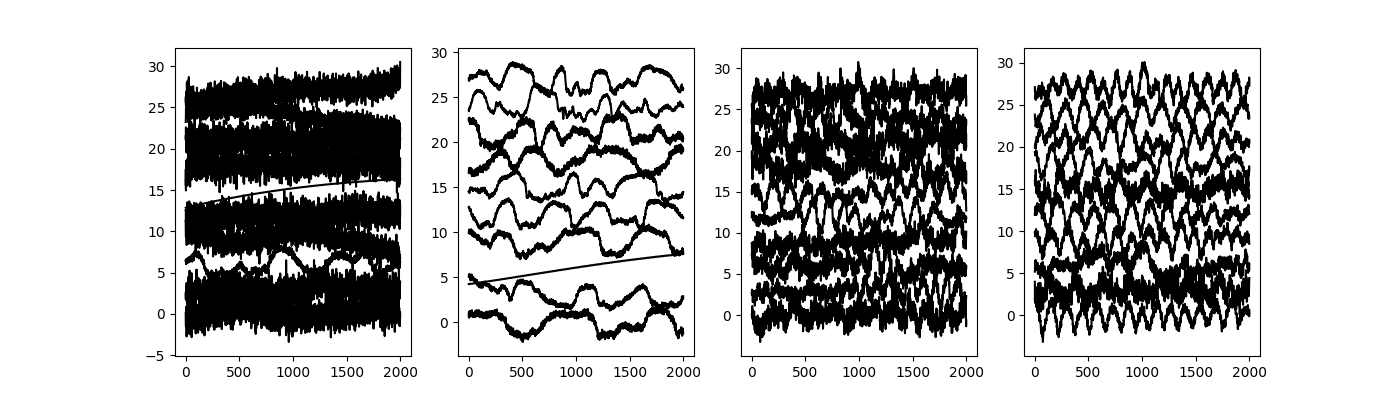

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))
for i in range(4):
    tdx = np.random.choice(np.where(np.array(states_all)==i)[0], 10)
    for jdx, j in enumerate(tdx):
        ax[i].plot(jdx*3 + data_all[j, :], c='k')

In [730]:
data_all.shape

(11402, 2000)

In [728]:
df_all

labels  time_indices      prob
0      unknown    20726499.0  0.831301
1      unknown    20748499.0  0.463644
2      unknown    20750499.0  0.649095
3      unknown    20772499.0  0.623702
4      unknown    20784499.0  0.703615
...        ...           ...       ...
11397  slow_MA    19373088.0  0.979378
11398  slow_MA    19375088.0  0.999675
11399  slow_MA    19379888.0  0.982784
11400  slow_MA    19397888.0  0.996276
11401  slow_MA    19401888.0  0.970736

[11402 rows x 3 columns]